# Hacettepe University
### BBM 409 4th ASSIGNMENT


#### Name and Surname: Fatih Pehlivan – Göktuğ Ocaklıoğlu
#### Identity Number: 21946529 - 2200356841
#### Course:  BBM 409

#### Advisor: Burçak Asal

In [1]:
from PIL import Image
import os
import numpy as np
import random
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
import time
import copy
import sys
import torchmetrics

# PART 2 : Convolutional Neural Network

In this part of the assignment, we will use pretrained VGG-19 convolutional neural network (CNN) and finetune this network to classify the sample images. We can see the architecture of vgg-19 and its parameters below. We will fine-tune these parameters.

<img src="vgg19 architecture.png" style='width:500px;height:200px'>

<img src="parameters.jpg" style='width:1000px;height:250px'>

## Part 2.1

We will fine tune the weights of all layers in the VGG-19 network in this section

In [2]:
num_epochs=10
batchs_size = 32

In [3]:
#Loading data 
data_dir = "Vegetable Images" 
data_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()])

trainloader = torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir,'train'), data_transforms), batch_size=batchs_size, shuffle=True)
validloader = torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir,'validation'), data_transforms), batch_size=batchs_size, shuffle=True)
testloader = torch.utils.data.DataLoader(datasets.ImageFolder(os.path.join(data_dir,'test'), data_transforms), batch_size=batchs_size, shuffle=True)
print("Initializing Dataloaders...")


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))
print(device)

Initializing Dataloaders...
cuda:0


The final layer of a VGG-19 CNN model, which is an FC layer (softmax), has the same number of nodes as the number of output classes in the dataset. Since the model have been pretrained on Imagenet, it have output layer of size 1000. Therefore we have to reshape the number of outputs in the last layer as the number of classes in our dataset. 

In [4]:
model_1 = models.vgg19(weights='VGG19_Weights.DEFAULT')
model_1.classifier[6] = nn.Linear(4096,15)
model_1 = model_1.to(device)

In [5]:
#In the VGG-19 model, the requires_grad of all parameters are True. So we can fine tune all parameters.
#Use a Classification Cross-Entropy loss and SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

In [6]:
def train_model(model, trainloader, validloader, criterion, optimizer, num_epochs=10):
    since = time.time()
    
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    min_loss = sys.float_info.max

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 20)
        
        #Train part
        model.train()
        
        train_loss = 0.0
        train_corrects = 0
        
        # get the inputs; trainloader is a list of [inputs, labels]
        for inputs, labels in trainloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            
            with torch.set_grad_enabled(True):
                 # forward 
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                #The outputs are energies for the 10 classes. 
                #The higher the energy for a class, the more the network thinks that the image is of the particular class. 
                #So, let’s get the index of the highest energy:
                _, preds = torch.max(outputs, 1)

                #backward + optimize
                loss.backward()
                optimizer.step()
            
            # print statistics
            train_loss += loss.item() * inputs.size(0)
            train_corrects += (preds == labels).sum().item()
        
        epoch_loss = train_loss / len(trainloader.dataset)
        epoch_acc = train_corrects / len(trainloader.dataset)
        train_acc_history.append(epoch_acc)
        train_loss_history.append(epoch_loss)
        print('Train: Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        
        
        #Validation part
        model.eval()
        
        validation_loss = 0.0
        validation_corrects = 0
        
        # get the inputs; trainloader is a list of [inputs, labels]
        for inputs, labels in validloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
                
            optimizer.zero_grad()
            # since we're not training, we don't need to calculate the gradients for our outputs
            with torch.set_grad_enabled(False):
                # forward 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
            # print statistics
            validation_loss += loss.item() * inputs.size(0)
            validation_corrects += (preds == labels).sum().item()
            
        epoch_loss = validation_loss / len(validloader.dataset)
        epoch_acc = validation_corrects / len(validloader.dataset)
        val_acc_history.append(epoch_acc)
        val_loss_history.append(epoch_loss)
        
        print('Validation: Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
        if epoch_loss < min_loss:
                min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                             
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Min Validation Loss: {:4f}'.format(min_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history         

In [7]:
def test_model(testloader, model):
    total_accuracy=0.0
    total_recall=0.0
    total_precision=0.0
    total_f1=0.0
    
    accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=15).to(device)
    recall = torchmetrics.Recall(task="multiclass", average='macro', num_classes=15).to(device)
    precision = torchmetrics.Precision(task="multiclass", average='macro', num_classes=15).to(device)
    f1 = torchmetrics.F1Score(task="multiclass",average='macro',   num_classes=15).to(device)
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            total_accuracy+=(accuracy(preds,labels).item()*inputs.size(0))
            total_recall+=(recall(preds,labels).item()*inputs.size(0))
            total_precision+=(precision(preds,labels).item()*inputs.size(0))
            total_f1+=(f1(preds,labels).item()*inputs.size(0))       
    
    print('Accuracy: ', (total_accuracy/len(testloader.dataset)))
    print('Recall: ', (total_recall/len(testloader.dataset)))
    print('Precision: ', (total_precision/len(testloader.dataset)))
    print('F1:', (total_f1/len(testloader.dataset)))

In [8]:
# Train and evaluate
model_1, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(model_1, trainloader, validloader, criterion, optimizer_1, num_epochs)
torch.save(model_1.state_dict(), 'model1')

Epoch 0/9
--------------------
Train: Loss: 0.1726 Acc: 0.9479
Validation: Loss: 0.0079 Acc: 0.9980
Epoch 1/9
--------------------
Train: Loss: 0.0139 Acc: 0.9961
Validation: Loss: 0.0046 Acc: 0.9987
Epoch 2/9
--------------------
Train: Loss: 0.0098 Acc: 0.9971
Validation: Loss: 0.0051 Acc: 0.9993
Epoch 3/9
--------------------
Train: Loss: 0.0037 Acc: 0.9989
Validation: Loss: 0.0041 Acc: 0.9993
Epoch 4/9
--------------------
Train: Loss: 0.0023 Acc: 0.9995
Validation: Loss: 0.0040 Acc: 0.9983
Epoch 5/9
--------------------
Train: Loss: 0.0029 Acc: 0.9991
Validation: Loss: 0.0030 Acc: 0.9997
Epoch 6/9
--------------------
Train: Loss: 0.0003 Acc: 1.0000
Validation: Loss: 0.0029 Acc: 0.9997
Epoch 7/9
--------------------
Train: Loss: 0.0003 Acc: 0.9999
Validation: Loss: 0.0031 Acc: 0.9990
Epoch 8/9
--------------------
Train: Loss: 0.0099 Acc: 0.9979
Validation: Loss: 0.0052 Acc: 0.9983
Epoch 9/9
--------------------
Train: Loss: 0.0005 Acc: 0.9998
Validation: Loss: 0.0024 Acc: 0.9997


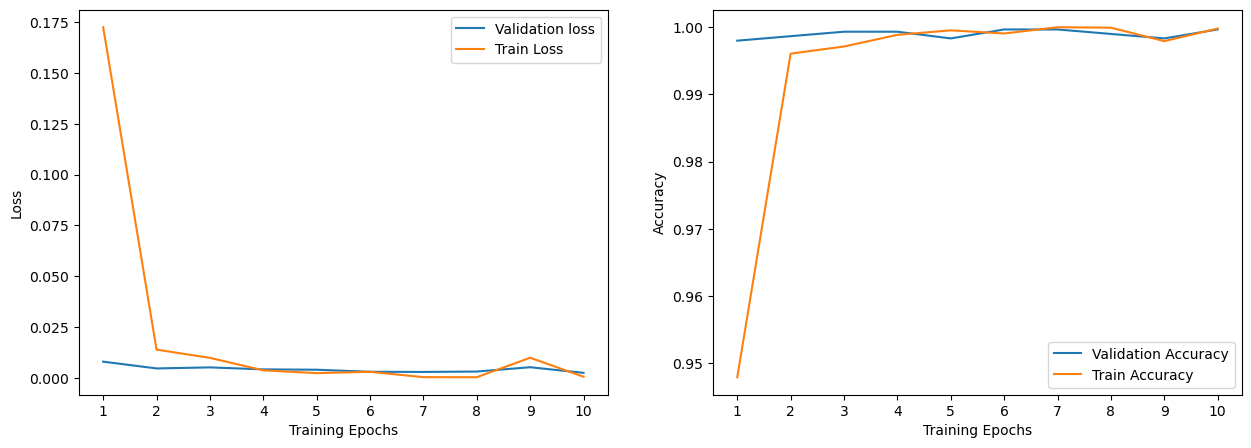

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1),val_loss_history,label="Validation loss")
plt.plot(range(1,num_epochs+1),train_loss_history,label="Train Loss")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1),val_acc_history,label="Validation Accuracy")
plt.plot(range(1,num_epochs+1),train_acc_history,label="Train Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()

plt.show()

In [10]:
test_model(testloader, model_1)

Accuracy:  0.9993333333333333
Recall:  0.910163012822469
Precision:  0.9103407910664876
F1: 0.910191795984904


# PART 2.2

For this part, we will finetune the weights of only two last fully connected (FC1 and FC2) layers in the VGG-19 network.

In [11]:
model_2 = models.vgg19(weights='VGG19_Weights.DEFAULT')

In [12]:
model_2.classifier[6] = nn.Linear(4096,15)
model_2 = model_2.to(device)

In [13]:
# requires_grad of all parameters except FC1 and FC2 must be False. 
for name, param in model_2.named_parameters():
    if ("classifier.0" in name or "classifier.3" in name):
        param.requires_grad=True
    else:
        param.requires_grad=False
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.16.weight False
features.16.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.23.weight False
features.23.bias False
features.25.weight False
features.25.bias False
features.28.weight False
features.28.bias False
features.30.weight False
features.30.bias False
features.32.weight False
features.32.bias False
features.34.weight False
features.34.bias False
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight False
classifier.6.bias False


In [14]:
# Observe that all parameters are being optimized
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

In [15]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_2, train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(model_2, trainloader, validloader, criterion, optimizer_2, num_epochs)
torch.save(model_1.state_dict(), 'model2')

Epoch 0/9
--------------------
Train: Loss: 0.7403 Acc: 0.8216
Validation: Loss: 0.1329 Acc: 0.9770
Epoch 1/9
--------------------
Train: Loss: 0.1457 Acc: 0.9655
Validation: Loss: 0.0645 Acc: 0.9863
Epoch 2/9
--------------------
Train: Loss: 0.0890 Acc: 0.9801
Validation: Loss: 0.0475 Acc: 0.9900
Epoch 3/9
--------------------
Train: Loss: 0.0608 Acc: 0.9868
Validation: Loss: 0.0359 Acc: 0.9917
Epoch 4/9
--------------------
Train: Loss: 0.0464 Acc: 0.9903
Validation: Loss: 0.0295 Acc: 0.9927
Epoch 5/9
--------------------
Train: Loss: 0.0361 Acc: 0.9933
Validation: Loss: 0.0262 Acc: 0.9927
Epoch 6/9
--------------------
Train: Loss: 0.0318 Acc: 0.9937
Validation: Loss: 0.0241 Acc: 0.9937
Epoch 7/9
--------------------
Train: Loss: 0.0263 Acc: 0.9955
Validation: Loss: 0.0218 Acc: 0.9940
Epoch 8/9
--------------------
Train: Loss: 0.0233 Acc: 0.9955
Validation: Loss: 0.0201 Acc: 0.9947
Epoch 9/9
--------------------
Train: Loss: 0.0196 Acc: 0.9967
Validation: Loss: 0.0190 Acc: 0.9943


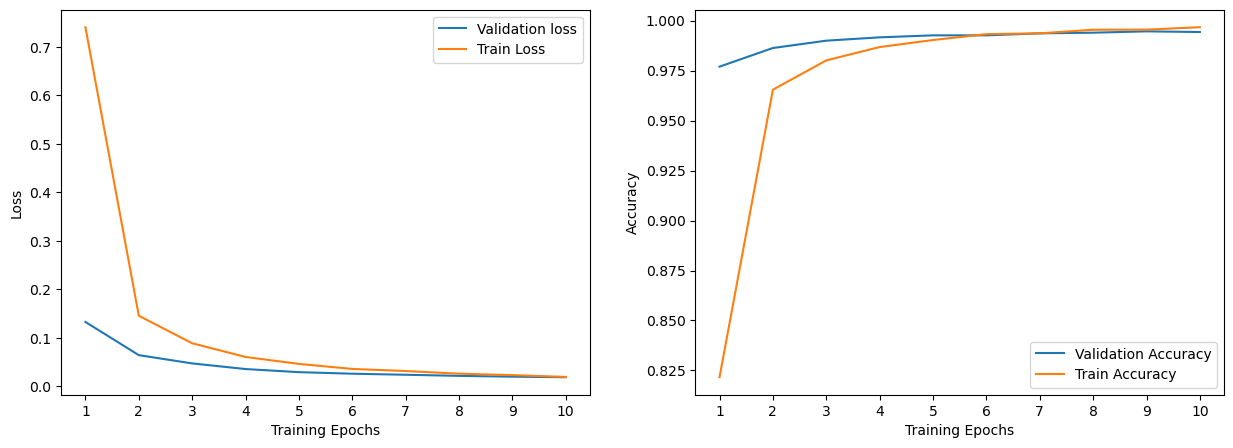

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1),val_loss_history,label="Validation loss")
plt.plot(range(1,num_epochs+1),train_loss_history,label="Train Loss")
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1),val_acc_history,label="Validation Accuracy")
plt.plot(range(1,num_epochs+1),train_acc_history,label="Train Accuracy")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")

plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()

plt.show()

In [17]:
test_model(testloader, model_2)

Accuracy:  0.997
Recall:  0.8962726475397745
Precision:  0.8966519066492716
F1: 0.896083581606547


When we compare our neural network and vgg19, it is seen that vgg19 performs much better when looking at the accuracy precision recall and f1 values. Convolutional neural networks (CNN) are well-suited for image processing tasks because they are able to features from input data. It contains convolutional layers that apply a set of learnable filters to the input data and are designed to detect a particular pattern or feature in the data.